# Time series graph

In [103]:
import pickle as p 
import pandas as pd 
import plotly.graph_objects as go

def get_data(data_name, ref_name):
    with open(f"../data/{ref_name}", 'rb') as f:
        inp_sig = p.load(f)
    with open(f"../data/{data_name}", 'rb') as f:
        data = p.load(f)
    return data, inp_sig

def make_sparkline(data, ref, title):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x = data["ts"],
            y = data[0],
            name = "Output",
            showlegend = True
        )
    )
    fig.add_trace(
        go.Scatter(
            x = data["ts"],
            y = ref["norm"],
            line=dict(
                width=0.3
            ),
            name = "Input (norm)"
        )
    )
    fig.update_layout(
        yaxis_title="Voltage (mV)",
        xaxis_title="Time (s)",
        font=dict(size=20),
        autosize=False,
        width=1200,
        height=500, 
    )
    fig.write_image(f"{title}_sparkline.png")

# Series name: [data name, ref data name, frequency adjust, norm input factor, offset]
graph_data = {
    "100 Hz": ["Two_blocks_100Hz", "Two_blocks_100Hz_ref", 50000, 0.01, 0.05],
    "1 KHz": ["Two_blocks_1000Hz", "Two_blocks_1000Hz_ref", 50000, 0.002, 0.005],
    "10 KHz": ["Two_blocks_10000Hz", "Two_blocks_10000Hz_ref", 50000, 0.002, 0.005]
}

fig = go.Figure()

plot_count = 0
for i, j in graph_data.items():
    data, ref_signal = get_data(j[0], j[1])
    sample_data = []
    chunk = 1000

    # Chunk data
    for k in range(len(data)):
        sample_data.append(data[k][0:chunk])

    # Load to dataframe
    sample_df = pd.DataFrame(sample_data).T
    ref_df    = pd.DataFrame(ref_signal[0:chunk])

    # Convert time stamp from frequency to time
    sample_df["ts"] = sample_df.index / j[2]

    # Normalise input signal size for display purposes
    ref_df["norm"] = ref_df[0] * j[3] + j[4]

    # Offset 10k trace for illustrative purposes
    if i == "10 KHz":
        sample_df[0] = sample_df[0] + 0.018

    # make_sparkline(sample_df, ref_df, i) # Fig with underlying frequency
    fig.add_trace(go.Scatter(  # Stacked figure
            x = sample_df["ts"],
            y = sample_df[0],
            name = f"Output, {i}",
            showlegend = True
        ) 
    )
    fig.update_layout(
        yaxis_title="Voltage (mV)",
        xaxis_title="Time (s)",
        font=dict(size=20),
        autosize=False,
        width=1200,
        height=500, 
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=0.75
            )
    )
    
    fig.write_image(f"multi_sparkline.png")

fig.show()


# CSD

In [194]:
import pickle
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

def fft_extract(data, pk_height = 1e-5): 
    
    ''' Takes a data channel and performs DFT:
        Input:
             data - data channel
        pk_hieght - allows for peak thresholding after the DFT
        
        Returns:
            pk_freq - list of the frequencies from the DFT in Hz
            pk_vals - list of values for pk_freq list
        '''
    
    ycubic  = data

    # FFT
    N       = len(ycubic)
    T       = 1 / 50000 #(len(x) / 50000) / len(x)
    yf      = fft(ycubic)
    xf      = fftfreq(N, T)[:N//2]
    yf_real = 2.0/N * np.abs(yf[0:N//2])

    peaks = signal.find_peaks(yf_real, height=pk_height)[0]

    # extract principle harmonics
    pk_vals = yf_real[peaks]
    pk_freq = xf[peaks]
        
    return pk_freq, pk_vals


fs  = 50000 # Sampling frequency used in all measurements # RM < was it really?

f_names = ["Two_blocks_100Hz",  "Two_blocks_200Hz",  "Two_blocks_300Hz",  "Two_blocks_400Hz",  "Two_blocks_500Hz",
            "Two_blocks_600Hz",  "Two_blocks_700Hz",  "Two_blocks_800Hz",  "Two_blocks_900Hz",  "Two_blocks_1000Hz",
            "Two_blocks_2000Hz", "Two_blocks_3000Hz", "Two_blocks_4000Hz", "Two_blocks_5000Hz", "Two_blocks_6000Hz",
            "Two_blocks_7000Hz", "Two_blocks_8000Hz", "Two_blocks_9000Hz", "Two_blocks_10000Hz"] 

collected_means  = []
collected_stds   = []
coll_sum_of_vals = []
coll_csd_max     = []
power_spectra_graph = []

for f_name in f_names:
    
    csd_max = []
    freqs   = []
    vals    = []
    csd     = []
    fc      = []
    tf      = []
    
    f_name = f"../data/{f_name}"
    ref_name = f_name + "_ref"
    with open(ref_name, 'rb') as f:
        inp_sig = pickle.load(f)
    
    with open(f_name, 'rb') as f:
        data = pickle.load(f)


    fp, psd  = signal.welch(inp_sig, fs, detrend='linear', nperseg=10000)   
    count = 0
    for sample in data:
        
        count = count + 1 # sanity check variable
    
        # Calculate Cross Spectral Denisty & transfer function - cros_csd, t_f
        f_c, cros_sd = signal.csd(inp_sig, sample, fs, detrend='linear', nperseg=10000)   
        t_f          = cros_sd / psd
        max_idx      = np.argmax(cros_sd)
    
        csd.append(cros_sd)
        fc.append(f_c)
        tf.append(t_f)
        # Round to 2 S.F. for frequency
        csd_max.append([cros_sd[max_idx], round(f_c[max_idx], -2)])
        
        # Calculate DFT
        pk_freq, pk_vals   = fft_extract(sample[1000:])
        freqs.append(pk_freq)
        vals.append(pk_vals)
    
    power_spectra_graph.append([fc[0:4], csd[0:4]])
        
    print(f"Processed {f_name}")  
    
    ## Collate data
    sum_of_vals  = [sum(val) for val in vals] 
    mean_of_vals = np.mean(sum_of_vals)
    std_of_vals  = np.std(sum_of_vals)
    collected_means.append(mean_of_vals)
    collected_stds.append(std_of_vals)
    coll_sum_of_vals.append(np.array(sum_of_vals))
    coll_csd_max.append(csd_max)

stats = pd.DataFrame()
fnames = [i.split("_")[-1] for i in f_names]
stats.index = fnames
stats["means"] = collected_means
stats["std"] = collected_stds
stats["sum"] = coll_sum_of_vals
stats["csd_max"] = coll_csd_max

Processed ../data/Two_blocks_100Hz
Processed ../data/Two_blocks_200Hz
Processed ../data/Two_blocks_300Hz
Processed ../data/Two_blocks_400Hz
Processed ../data/Two_blocks_500Hz
Processed ../data/Two_blocks_600Hz
Processed ../data/Two_blocks_700Hz
Processed ../data/Two_blocks_800Hz
Processed ../data/Two_blocks_900Hz
Processed ../data/Two_blocks_1000Hz
Processed ../data/Two_blocks_2000Hz
Processed ../data/Two_blocks_3000Hz
Processed ../data/Two_blocks_4000Hz
Processed ../data/Two_blocks_5000Hz
Processed ../data/Two_blocks_6000Hz
Processed ../data/Two_blocks_7000Hz
Processed ../data/Two_blocks_8000Hz
Processed ../data/Two_blocks_9000Hz
Processed ../data/Two_blocks_10000Hz


# Amplitudes 

In [15]:
f_names = ["Two_blocks_100Hz",  "Two_blocks_200Hz",  "Two_blocks_300Hz",  "Two_blocks_400Hz",  "Two_blocks_500Hz",
            "Two_blocks_600Hz",  "Two_blocks_700Hz",  "Two_blocks_800Hz",  "Two_blocks_900Hz",  "Two_blocks_1000Hz",
            "Two_blocks_2000Hz", "Two_blocks_3000Hz", "Two_blocks_4000Hz", "Two_blocks_5000Hz", "Two_blocks_6000Hz",
            "Two_blocks_7000Hz", "Two_blocks_8000Hz", "Two_blocks_9000Hz", "Two_blocks_10000Hz"] 
plot_f_names = ["Two_blocks_100Hz",  "Two_blocks_1000Hz", "Two_blocks_10000Hz"] 

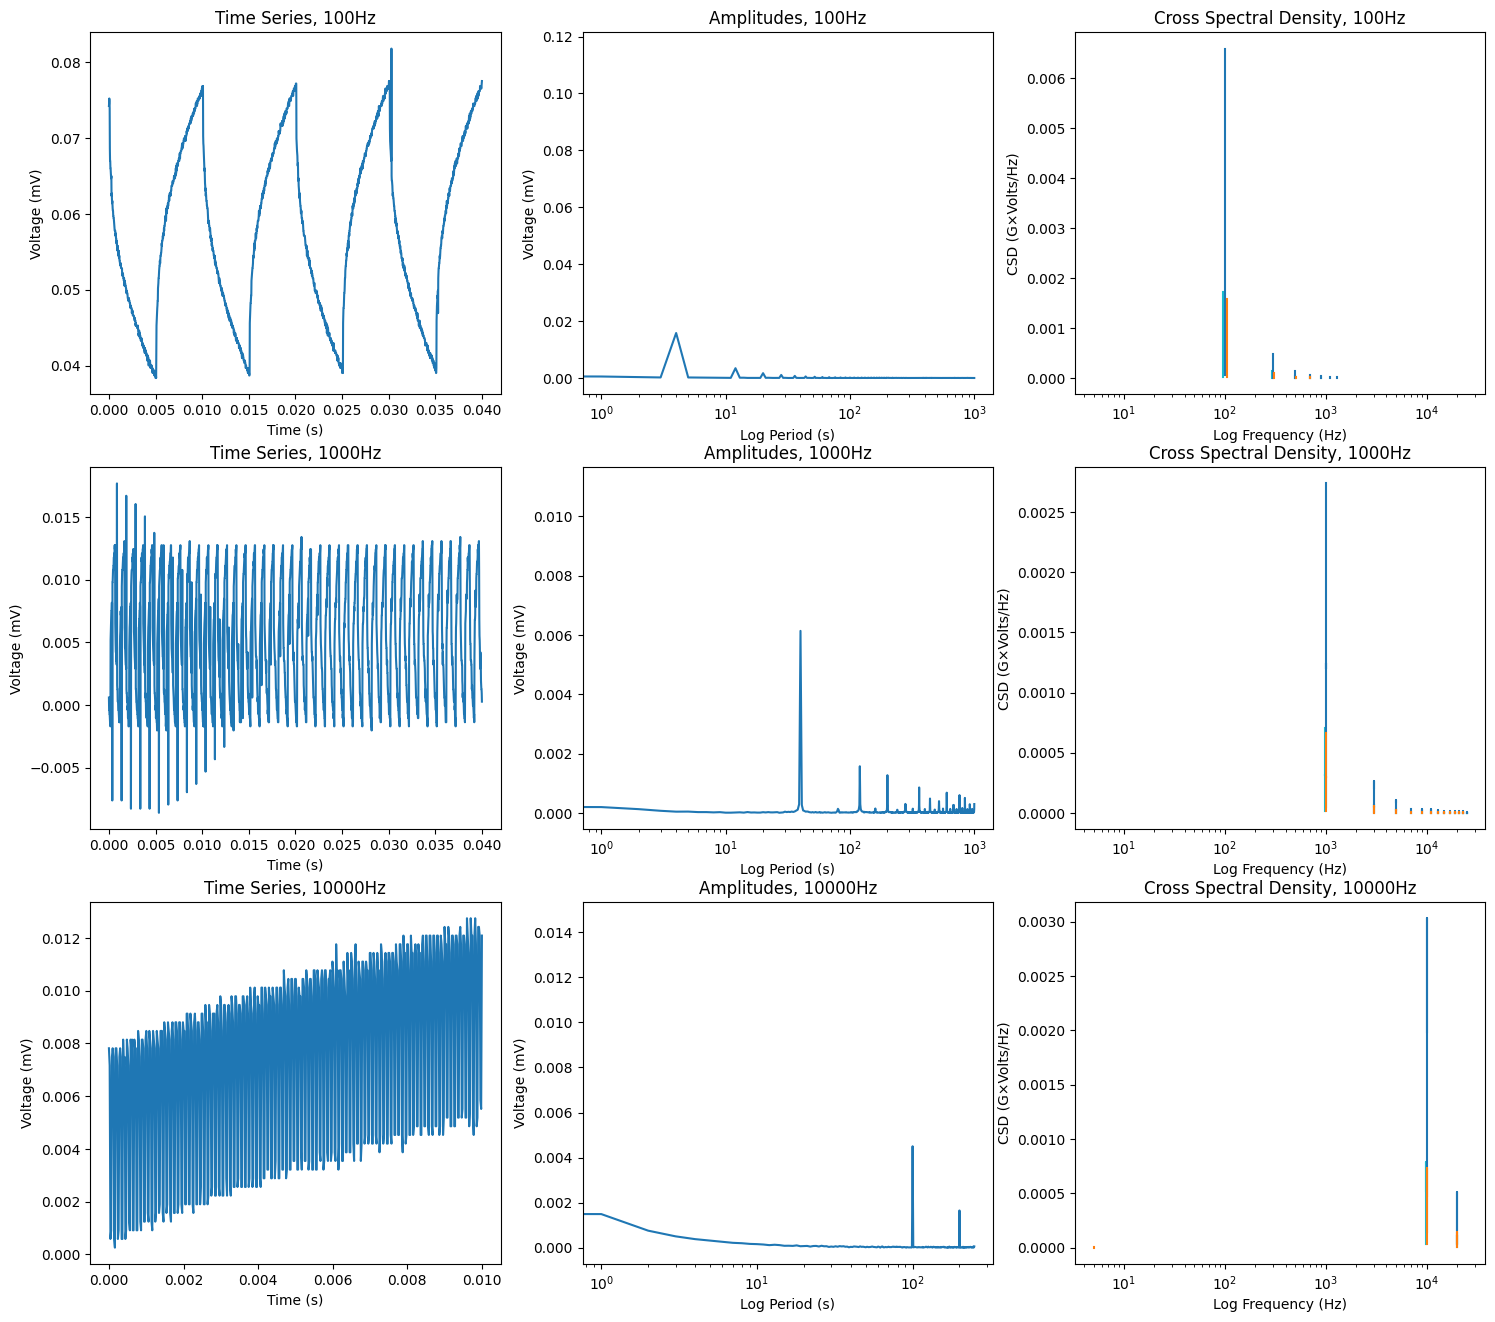

In [235]:
fig_data = []
spectra_we_want = [power_spectra_graph[i] for i in range(len(f_names)) if f_names[i] in plot_f_names]

def get_amplitude(data, name):
    t0 = 0.00
    t1 = 0.04
    sig_len = 2000
    if name == "Two_blocks_10000Hz":
        sig_len = 500
        t1 = 0.01
    sig = data[100:sig_len+100]
    amplitudes = 2 / sig_len * np.abs(np.fft.fft(sig))
    xs = np.linspace(t0, t1, sig_len)
    frequencies = np.fft.fftfreq(sig_len) * sig_len * 1 / (1 - 0)
    return [xs, sig, frequencies, amplitudes]

for i in plot_f_names:
    f_name = f"../data/{i}"    
    with open(f_name, 'rb') as f:
        data = pickle.load(f)
    
    fig_data.append(get_amplitude(data[0], i))

fnames_freq = [i.split("_")[-1] for i in plot_f_names]
plt_cnt = 1
f = plt.figure(figsize=(18,16))
for idx in range(len(fig_data)):
    # plt xs, sig
    ax = f.add_subplot(len(fig_data), 3, plt_cnt)
    ax.set_title(f"Time Series, {fnames_freq[idx]}")
    ax.set_xlabel(f"Time (s)")
    ax.set_ylabel(f"Voltage (mV)")
    ax.plot(fig_data[idx][0], fig_data[idx][1])
    plt_cnt += 1

    # plt amplitudes (semilogx or plot?)
    ax = f.add_subplot(len(fig_data), 3, plt_cnt)
    ax.set_title(f"Amplitudes, {fnames_freq[idx]}")
    ax.set_xlabel(f"Log Period (s)")
    ax.set_ylabel(f"Voltage (mV)")
    ax.semilogx(fig_data[idx][2][:len(fig_data[idx][2]) // 2], fig_data[idx][3][:len(np.fft.fft(fig_data[idx][1])) // 2])
    plt_cnt += 1

    # plt power spectra 
    ax = f.add_subplot(len(fig_data), 3, plt_cnt)
    ax.set_title(f"Cross Spectral Density, {fnames_freq[idx]}")
    ax.set_xlabel(f"Log Frequency (Hz)")
    ax.set_ylabel(f"CSD (G×Volts/Hz)")
    ax.semilogx(spectra_we_want[idx][0][0:4], np.abs(spectra_we_want[idx][1][0:4]))
    plt_cnt += 1




# Recoverable frequencies

In [259]:
def count_recovered_freqs(row):
    input_freq = int(row['labels'].replace('Hz',''))
    count = 0
    for i in row["csd_max"]:
        if int(i[1]) >= input_freq and int(i[1]) % input_freq == 0:
            count += 1
    return count 
    
stats["labels"] = stats.index
stats["n_recovered_freqs"] = stats.apply(lambda x: count_recovered_freqs(x), axis = 1)
stats["n_recovered_freqs_pc"] = round(stats["n_recovered_freqs"] / 28 * 100, 2)
stats["n_recovered_freqs_pc"]

100Hz      100.00
200Hz      100.00
300Hz      100.00
400Hz      100.00
500Hz      100.00
600Hz      100.00
700Hz      100.00
800Hz       96.43
900Hz       96.43
1000Hz     100.00
2000Hz     100.00
3000Hz      82.14
4000Hz      85.71
5000Hz     100.00
6000Hz      60.71
7000Hz      71.43
8000Hz      78.57
9000Hz      46.43
10000Hz     96.43
Name: n_recovered_freqs_pc, dtype: float64

In [471]:
from scipy.stats import iqr
# Print aggregate mean and standard dev for percentage with recoverable frequencies
np.median(stats["n_recovered_freqs_pc"]), iqr(stats["n_recovered_freqs_pc"])

(100.0, 16.075000000000003)

# Augmented Dickey Fuller

In [470]:
from statsmodels.tsa.stattools import adfuller

adfs = []
for f_name in f_names:
    f_name = f"../data/{f_name}"
    ref_name = f_name + "_ref"    
    with open(f_name, 'rb') as f:
        data = pickle.load(f)

    cnt = 0
    for i in data:
        if adfuller(i[0:100])[1] < 0.05:
            cnt += 1
    
    print(f"For {f_name}, percent at p<0.05: {cnt/28 * 100}")
    adfs.append(cnt/28 * 100)

ad_np = np.array(adfs)
me = np.median(ad_np)
intqr = iqr(ad_np)
# Print aggregate mean and IQR
me, intqr

For ../data/Two_blocks_100Hz, percent at p<0.05: 82.14285714285714
For ../data/Two_blocks_200Hz, percent at p<0.05: 75.0
For ../data/Two_blocks_300Hz, percent at p<0.05: 60.71428571428571
For ../data/Two_blocks_400Hz, percent at p<0.05: 35.714285714285715
For ../data/Two_blocks_500Hz, percent at p<0.05: 35.714285714285715
For ../data/Two_blocks_600Hz, percent at p<0.05: 39.285714285714285
For ../data/Two_blocks_700Hz, percent at p<0.05: 53.57142857142857
For ../data/Two_blocks_800Hz, percent at p<0.05: 60.71428571428571
For ../data/Two_blocks_900Hz, percent at p<0.05: 57.14285714285714
For ../data/Two_blocks_1000Hz, percent at p<0.05: 50.0
For ../data/Two_blocks_2000Hz, percent at p<0.05: 100.0
For ../data/Two_blocks_3000Hz, percent at p<0.05: 100.0
For ../data/Two_blocks_4000Hz, percent at p<0.05: 92.85714285714286
For ../data/Two_blocks_5000Hz, percent at p<0.05: 71.42857142857143
For ../data/Two_blocks_6000Hz, percent at p<0.05: 96.42857142857143
For ../data/Two_blocks_7000Hz, perce

(71.42857142857143, 37.49999999999999)

# Mean Amplitudes

In [324]:
all_amps = {}
for i in f_names:
    f_name = f"../data/{i}"    
    with open(f_name, 'rb') as f:
        data = pickle.load(f)
    
    trace_data = []
    for j in data:
        trace_data.append(get_amplitude(j, i)[3])
    all_amps[i] = trace_data


In [477]:
means_by_freq = {}
all_means = []

for i in all_amps.keys():
    means = []
    for j in all_amps[i]:
        means.append(np.max(j)), all_means.append(np.max(j))
    means_by_freq[i] = [round(np.mean(means), 3), round(iqr(means), 3)]

# Print mean and IQR for amplitudes at each frequency
[i for i in means_by_freq.items()]

[('Two_blocks_100Hz', [0.2, 0.173]),
 ('Two_blocks_200Hz', [0.093, 0.061]),
 ('Two_blocks_300Hz', [0.069, 0.051]),
 ('Two_blocks_400Hz', [0.066, 0.059]),
 ('Two_blocks_500Hz', [0.077, 0.063]),
 ('Two_blocks_600Hz', [0.088, 0.086]),
 ('Two_blocks_700Hz', [0.083, 0.091]),
 ('Two_blocks_800Hz', [0.077, 0.087]),
 ('Two_blocks_900Hz', [0.083, 0.1]),
 ('Two_blocks_1000Hz', [0.085, 0.104]),
 ('Two_blocks_2000Hz', [0.081, 0.107]),
 ('Two_blocks_3000Hz', [0.081, 0.096]),
 ('Two_blocks_4000Hz', [0.084, 0.105]),
 ('Two_blocks_5000Hz', [0.078, 0.09]),
 ('Two_blocks_6000Hz', [0.073, 0.095]),
 ('Two_blocks_7000Hz', [0.083, 0.106]),
 ('Two_blocks_8000Hz', [0.092, 0.089]),
 ('Two_blocks_9000Hz', [0.08, 0.086]),
 ('Two_blocks_10000Hz', [0.076, 0.093])]

In [478]:
# Aggregate mean and IQR of all measurements combined
np.mean(all_means), iqr(all_means)

(0.08677568685320665, 0.09757394172587201)

In [479]:
from scipy.stats import anderson

# Double check no mean amplitude series are normally distributed
for j in amp_values_for_anova:
    for i in j:
        res = anderson(i)
        if res.statistic < res.critical_values[2]:
            print("Normal")


In [480]:
from scipy.stats import f_oneway, kruskal
amp_values_for_anova = [i for i in all_amps.values()]
f, p = kruskal(amp_values_for_anova[0], amp_values_for_anova[1], amp_values_for_anova[2], amp_values_for_anova[3], amp_values_for_anova[4], amp_values_for_anova[5], amp_values_for_anova[6], amp_values_for_anova[7], amp_values_for_anova[8], amp_values_for_anova[9], amp_values_for_anova[10],
         amp_values_for_anova[11], amp_values_for_anova[12], amp_values_for_anova[13], amp_values_for_anova[14], amp_values_for_anova[15], amp_values_for_anova[16], amp_values_for_anova[17],
         axis=1)

In [481]:
idx = 0
means_by_freq_stat = means_by_freq.copy()
for i in means_by_freq_stat.items():
    i[1].append(p[idx])
    idx += 1
# Print out with one way anova p value in array
means_by_freq_stat

{'Two_blocks_100Hz': [0.2, 0.173, 0.0],
 'Two_blocks_200Hz': [0.093, 0.061, 0.0],
 'Two_blocks_300Hz': [0.069, 0.051, 0.0],
 'Two_blocks_400Hz': [0.066, 0.059, 1.2397747505455367e-161],
 'Two_blocks_500Hz': [0.077, 0.063, 0.0],
 'Two_blocks_600Hz': [0.088, 0.086, 0.0],
 'Two_blocks_700Hz': [0.083, 0.091, 3.269175367533636e-237],
 'Two_blocks_800Hz': [0.077, 0.087, 0.0],
 'Two_blocks_900Hz': [0.083, 0.1, 0.0],
 'Two_blocks_1000Hz': [0.085, 0.104, 0.0],
 'Two_blocks_2000Hz': [0.081, 0.107, 0.0],
 'Two_blocks_3000Hz': [0.081, 0.096, 0.0],
 'Two_blocks_4000Hz': [0.084, 0.105, 0.0],
 'Two_blocks_5000Hz': [0.078, 0.09, 0.0],
 'Two_blocks_6000Hz': [0.073, 0.095, 0.0],
 'Two_blocks_7000Hz': [0.083, 0.106, 0.0],
 'Two_blocks_8000Hz': [0.092, 0.089, 0.0],
 'Two_blocks_9000Hz': [0.08, 0.086, 0.0],
 'Two_blocks_10000Hz': [0.076, 0.093, 0.0]}

# Granger Causality

In [482]:
# Difference time series

In [3]:
def get_lags(a,b):
    correlation = np.correlate(a, b, mode='same')
    return np.abs(np.argmax(correlation) - int(len(correlation)/2))

In [8]:
# Do test
from statsmodels.tsa.stattools import grangercausalitytests as gct 
import pickle 
import pandas as pd
import numpy as np

all_granger_stats = {}

for f_name in f_names:
    f_name = f"../data/{f_name}"
    ref_name = f_name + "_ref"
    with open(ref_name, 'rb') as f:
        inp_sig = pickle.load(f)
    with open(f_name, 'rb') as f:
        data = pickle.load(f)

    within_freq_stats = []
    for i in data:
        th = pd.DataFrame()
        th["output"] = i[0:10000]
        th["input"] = inp_sig[0:10000]
        th = th.fillna("0")
        LAGS = get_lags(th["input"], th["output"])
        print(f"******************LAGS: {LAGS}")
        if LAGS > 350:
            LAGS = 350
        elif LAGS == 0:
            LAGS = 1
        res = gct(th[["output", "input"]],maxlag=[LAGS])
        within_freq_stats.append(res[LAGS][0]["ssr_chi2test"][1])
    
    all_granger_stats[f_name] = within_freq_stats

******************LAGS: 32

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=88.4642 , p=0.0000  , df_denom=9903, df_num=32
ssr based chi2 test:   chi2=2849.4358, p=0.0000  , df=32
likelihood ratio test: chi2=2506.2189, p=0.0000  , df=32
parameter F test:         F=88.4642 , p=0.0000  , df_denom=9903, df_num=32
******************LAGS: 354

Granger Causality
number of lags (no zero) 350
ssr based F test:         F=4.4315  , p=0.0000  , df_denom=8949, df_num=350
ssr based chi2 test:   chi2=1672.5134, p=0.0000  , df=350
likelihood ratio test: chi2=1542.4093, p=0.0000  , df=350
parameter F test:         F=4.4315  , p=0.0000  , df_denom=8949, df_num=350
******************LAGS: 354

Granger Causality
number of lags (no zero) 350
ssr based F test:         F=9.1301  , p=0.0000  , df_denom=8949, df_num=350
ssr based chi2 test:   chi2=3445.8653, p=0.0000  , df=350
likelihood ratio test: chi2=2946.5179, p=0.0000  , df=350
parameter F test:         F=9.1301  , p=0.0000  , 

In [14]:
# Print aggregate stats
from scipy.stats import iqr
runner = []
for i in all_granger_stats.keys():
    cnt = [1 for i in all_granger_stats[i] if float(i) > 0.05]
    print(f"sample {i}: {round(1 - (sum(cnt) / 28), 4)}")
    runner.append(round(1 - (sum(cnt) / 28), 4) * 100)

print(f"Aggregate: {np.median(runner)} ({iqr(runner)})")

sample ../data/Two_blocks_100Hz: 1.0
sample ../data/Two_blocks_200Hz: 0.9643
sample ../data/Two_blocks_300Hz: 1.0
sample ../data/Two_blocks_400Hz: 1.0
sample ../data/Two_blocks_500Hz: 0.8571
sample ../data/Two_blocks_600Hz: 0.9286
sample ../data/Two_blocks_700Hz: 1.0
sample ../data/Two_blocks_800Hz: 1.0
sample ../data/Two_blocks_900Hz: 1.0
sample ../data/Two_blocks_1000Hz: 0.75
sample ../data/Two_blocks_2000Hz: 0.75
sample ../data/Two_blocks_3000Hz: 0.9643
sample ../data/Two_blocks_4000Hz: 0.8214
sample ../data/Two_blocks_5000Hz: 0.9643
sample ../data/Two_blocks_6000Hz: 0.9643
sample ../data/Two_blocks_7000Hz: 1.0
sample ../data/Two_blocks_8000Hz: 0.9643
sample ../data/Two_blocks_9000Hz: 1.0
sample ../data/Two_blocks_10000Hz: 0.7857
Aggregate: 96.43 (10.715000000000003)
